In [15]:
# train for reconstruct whole image, no mask

import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torchvision import transforms, utils
from tqdm import tqdm

from models.cvqvae import CVQVAE
from utils.dataset_new import FullImageDataset



In [16]:
# hyperparameters
IMAGE_SIZE = 256
BATCH_SIZE = 16

EPOCHS = 100
LR = 0.0002

DATA_DIR = "./data/train"
SAVE_DIR = "samples_64_full"
os.makedirs(SAVE_DIR, exist_ok=True)



In [17]:
# for debugging: check if data is available
DATA_DIR = "./data/train/bg1k_imgs"
print("Files in fg_dir:", os.listdir(DATA_DIR))


Files in fg_dir: ['.ipynb_checkpoints', '0.png', '1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '11.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '12.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127.png', '128.png', '129.png', '13.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '14.png', '140.png', '141.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '15.png', '150.png', '151.png', '152.png', '153.png', '154.png', '155.png', '156.png', '157.png', '158.png', '159.png', '16.png', '160.png', '161.png', '162.png', '163.png', '164.png', '165.png', '166.png', '167.png', '168.png', '169.png', '17.png', '170.png', '171.png', '172.png', '173.png', '174.png', '175.png', '176.png', '177.png', '178

In [18]:

# transform
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# load dataset
full_dataset = FullImageDataset(DATA_DIR, transform=transform)

# divide dataset into train, val, and test sets as 80%, 10%, 10%
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [19]:
# initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVQVAE(num_embeddings=512, embedding_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [20]:
train_losses = []
val_losses = []

# training
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for full in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        full = full.to(device)

        optimizer.zero_grad() # reset gradients
        recon, vq_loss = model(full, full)  # input and target are the same
        recon_loss = F.mse_loss(recon, full) # reconstruction loss
        loss = recon_loss + vq_loss # total loss
        loss.backward() # backpropagation
        optimizer.step()  # update weights
        total_loss += loss.item() # accumulate loss

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    # evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for full in val_loader:
            full = full.to(device)
            recon, vq_loss = model(full, full)
            recon_loss = F.mse_loss(recon, full)
            val_loss += (recon_loss + vq_loss).item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} Val Loss: {avg_val_loss:.4f}")

    # save sample images
    with torch.no_grad():
        recon, _ = model(full[:8], full[:8])
        utils.save_image(torch.cat([full[:8], recon], dim=0), f"{SAVE_DIR}/epoch{epoch+1}.png", nrow=8)

    # save model
    if epoch + 1 == EPOCHS:
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, "vqvae_without_mask.pth"))



Train Epoch 1: 100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


Epoch 1 Train Loss: 0.1047
Epoch 1 Val Loss: 0.1923


Train Epoch 2: 100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Epoch 2 Train Loss: 0.9838
Epoch 2 Val Loss: 1.0162


Train Epoch 3: 100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


Epoch 3 Train Loss: 1.3916
Epoch 3 Val Loss: 1.5550


Train Epoch 4: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


Epoch 4 Train Loss: 1.1706
Epoch 4 Val Loss: 0.9189


Train Epoch 5: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


Epoch 5 Train Loss: 0.8194
Epoch 5 Val Loss: 0.6602


Train Epoch 6: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


Epoch 6 Train Loss: 0.6656
Epoch 6 Val Loss: 0.5271


Train Epoch 7: 100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Epoch 7 Train Loss: 0.5307
Epoch 7 Val Loss: 0.4203


Train Epoch 8: 100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


Epoch 8 Train Loss: 0.4245
Epoch 8 Val Loss: 0.3307


Train Epoch 9: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


Epoch 9 Train Loss: 0.3440
Epoch 9 Val Loss: 0.2886


Train Epoch 10: 100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


Epoch 10 Train Loss: 0.3088
Epoch 10 Val Loss: 0.2387


Train Epoch 11: 100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


Epoch 11 Train Loss: 0.2441
Epoch 11 Val Loss: 0.1876


Train Epoch 12: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Epoch 12 Train Loss: 0.2022
Epoch 12 Val Loss: 0.1932


Train Epoch 13: 100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Epoch 13 Train Loss: 0.2053
Epoch 13 Val Loss: 0.1991


Train Epoch 14: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Epoch 14 Train Loss: 0.1934
Epoch 14 Val Loss: 0.1867


Train Epoch 15: 100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Epoch 15 Train Loss: 0.1800
Epoch 15 Val Loss: 0.1740


Train Epoch 16: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Epoch 16 Train Loss: 0.1827
Epoch 16 Val Loss: 0.1786


Train Epoch 17: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


Epoch 17 Train Loss: 0.1618
Epoch 17 Val Loss: 0.1445


Train Epoch 18: 100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


Epoch 18 Train Loss: 0.1431
Epoch 18 Val Loss: 0.1422


Train Epoch 19: 100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


Epoch 19 Train Loss: 0.1402
Epoch 19 Val Loss: 0.1302


Train Epoch 20: 100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


Epoch 20 Train Loss: 0.1229
Epoch 20 Val Loss: 0.1250


Train Epoch 21: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Epoch 21 Train Loss: 0.1148
Epoch 21 Val Loss: 0.1068


Train Epoch 22: 100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


Epoch 22 Train Loss: 0.1011
Epoch 22 Val Loss: 0.0972


Train Epoch 23: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Epoch 23 Train Loss: 0.0896
Epoch 23 Val Loss: 0.0827


Train Epoch 24: 100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


Epoch 24 Train Loss: 0.0790
Epoch 24 Val Loss: 0.0943


Train Epoch 25: 100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


Epoch 25 Train Loss: 0.0897
Epoch 25 Val Loss: 0.0915


Train Epoch 26: 100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


Epoch 26 Train Loss: 0.0812
Epoch 26 Val Loss: 0.0810


Train Epoch 27: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


Epoch 27 Train Loss: 0.0752
Epoch 27 Val Loss: 0.0833


Train Epoch 28: 100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


Epoch 28 Train Loss: 0.0679
Epoch 28 Val Loss: 0.0677


Train Epoch 29: 100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


Epoch 29 Train Loss: 0.0606
Epoch 29 Val Loss: 0.0626


Train Epoch 30: 100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


Epoch 30 Train Loss: 0.0565
Epoch 30 Val Loss: 0.0654


Train Epoch 31: 100%|██████████| 50/50 [00:23<00:00,  2.08it/s]


Epoch 31 Train Loss: 0.0483
Epoch 31 Val Loss: 0.0507


Train Epoch 32: 100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


Epoch 32 Train Loss: 0.0438
Epoch 32 Val Loss: 0.0454


Train Epoch 33: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


Epoch 33 Train Loss: 0.0394
Epoch 33 Val Loss: 0.0435


Train Epoch 34: 100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


Epoch 34 Train Loss: 0.0363
Epoch 34 Val Loss: 0.0422


Train Epoch 35: 100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


Epoch 35 Train Loss: 0.0350
Epoch 35 Val Loss: 0.0410


Train Epoch 36: 100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


Epoch 36 Train Loss: 0.0336
Epoch 36 Val Loss: 0.0368


Train Epoch 37: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


Epoch 37 Train Loss: 0.0320
Epoch 37 Val Loss: 0.0359


Train Epoch 38: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


Epoch 38 Train Loss: 0.0305
Epoch 38 Val Loss: 0.0355


Train Epoch 39: 100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


Epoch 39 Train Loss: 0.0298
Epoch 39 Val Loss: 0.0343


Train Epoch 40: 100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


Epoch 40 Train Loss: 0.0293
Epoch 40 Val Loss: 0.0320


Train Epoch 41: 100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Epoch 41 Train Loss: 0.0283
Epoch 41 Val Loss: 0.0313


Train Epoch 42: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Epoch 42 Train Loss: 0.0267
Epoch 42 Val Loss: 0.0298


Train Epoch 43: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Epoch 43 Train Loss: 0.0253
Epoch 43 Val Loss: 0.0293


Train Epoch 44: 100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


Epoch 44 Train Loss: 0.0240
Epoch 44 Val Loss: 0.0282


Train Epoch 45: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


Epoch 45 Train Loss: 0.0231
Epoch 45 Val Loss: 0.0259


Train Epoch 46: 100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Epoch 46 Train Loss: 0.0219
Epoch 46 Val Loss: 0.0253


Train Epoch 47: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 47 Train Loss: 0.0212
Epoch 47 Val Loss: 0.0238


Train Epoch 48: 100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


Epoch 48 Train Loss: 0.0204
Epoch 48 Val Loss: 0.0235


Train Epoch 49: 100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Epoch 49 Train Loss: 0.0198
Epoch 49 Val Loss: 0.0227


Train Epoch 50: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 50 Train Loss: 0.0191
Epoch 50 Val Loss: 0.0215


Train Epoch 51: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Epoch 51 Train Loss: 0.0184
Epoch 51 Val Loss: 0.0209


Train Epoch 52: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 52 Train Loss: 0.0184
Epoch 52 Val Loss: 0.0211


Train Epoch 53: 100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Epoch 53 Train Loss: 0.0179
Epoch 53 Val Loss: 0.0200


Train Epoch 54: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Epoch 54 Train Loss: 0.0174
Epoch 54 Val Loss: 0.0199


Train Epoch 55: 100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Epoch 55 Train Loss: 0.0172
Epoch 55 Val Loss: 0.0193


Train Epoch 56: 100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Epoch 56 Train Loss: 0.0170
Epoch 56 Val Loss: 0.0187


Train Epoch 57: 100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Epoch 57 Train Loss: 0.0166
Epoch 57 Val Loss: 0.0189


Train Epoch 58: 100%|██████████| 50/50 [00:22<00:00,  2.17it/s]


Epoch 58 Train Loss: 0.0163
Epoch 58 Val Loss: 0.0183


Train Epoch 59: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 59 Train Loss: 0.0158
Epoch 59 Val Loss: 0.0170


Train Epoch 60: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 60 Train Loss: 0.0153
Epoch 60 Val Loss: 0.0167


Train Epoch 61: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 61 Train Loss: 0.0147
Epoch 61 Val Loss: 0.0162


Train Epoch 62: 100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Epoch 62 Train Loss: 0.0144
Epoch 62 Val Loss: 0.0154


Train Epoch 63: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 63 Train Loss: 0.0142
Epoch 63 Val Loss: 0.0150


Train Epoch 64: 100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


Epoch 64 Train Loss: 0.0137
Epoch 64 Val Loss: 0.0147


Train Epoch 65: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Epoch 65 Train Loss: 0.0135
Epoch 65 Val Loss: 0.0145


Train Epoch 66: 100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


Epoch 66 Train Loss: 0.0132
Epoch 66 Val Loss: 0.0143


Train Epoch 67: 100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Epoch 67 Train Loss: 0.0130
Epoch 67 Val Loss: 0.0139


Train Epoch 68: 100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


Epoch 68 Train Loss: 0.0128
Epoch 68 Val Loss: 0.0136


Train Epoch 69: 100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


Epoch 69 Train Loss: 0.0125
Epoch 69 Val Loss: 0.0133


Train Epoch 70: 100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


Epoch 70 Train Loss: 0.0121
Epoch 70 Val Loss: 0.0129


Train Epoch 71: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


Epoch 71 Train Loss: 0.0118
Epoch 71 Val Loss: 0.0125


Train Epoch 72: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


Epoch 72 Train Loss: 0.0115
Epoch 72 Val Loss: 0.0121


Train Epoch 73: 100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


Epoch 73 Train Loss: 0.0113
Epoch 73 Val Loss: 0.0117


Train Epoch 74: 100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


Epoch 74 Train Loss: 0.0111
Epoch 74 Val Loss: 0.0116


Train Epoch 75: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


Epoch 75 Train Loss: 0.0111
Epoch 75 Val Loss: 0.0115


Train Epoch 76: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Epoch 76 Train Loss: 0.0110
Epoch 76 Val Loss: 0.0113


Train Epoch 77: 100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


Epoch 77 Train Loss: 0.0108
Epoch 77 Val Loss: 0.0113


Train Epoch 78: 100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Epoch 78 Train Loss: 0.0108
Epoch 78 Val Loss: 0.0112


Train Epoch 79: 100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Epoch 79 Train Loss: 0.0107
Epoch 79 Val Loss: 0.0110


Train Epoch 80: 100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


Epoch 80 Train Loss: 0.0106
Epoch 80 Val Loss: 0.0109


Train Epoch 81: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


Epoch 81 Train Loss: 0.0104
Epoch 81 Val Loss: 0.0107


Train Epoch 82: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


Epoch 82 Train Loss: 0.0104
Epoch 82 Val Loss: 0.0107


Train Epoch 83: 100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Epoch 83 Train Loss: 0.0103
Epoch 83 Val Loss: 0.0106


Train Epoch 84: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


Epoch 84 Train Loss: 0.0103
Epoch 84 Val Loss: 0.0106


Train Epoch 85: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Epoch 85 Train Loss: 0.0101
Epoch 85 Val Loss: 0.0102


Train Epoch 86: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Epoch 86 Train Loss: 0.0099
Epoch 86 Val Loss: 0.0103


Train Epoch 87: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Epoch 87 Train Loss: 0.0097
Epoch 87 Val Loss: 0.0099


Train Epoch 88: 100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Epoch 88 Train Loss: 0.0096
Epoch 88 Val Loss: 0.0096


Train Epoch 89: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Epoch 89 Train Loss: 0.0094
Epoch 89 Val Loss: 0.0095


Train Epoch 90: 100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


Epoch 90 Train Loss: 0.0094
Epoch 90 Val Loss: 0.0094


Train Epoch 91: 100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Epoch 91 Train Loss: 0.0093
Epoch 91 Val Loss: 0.0094


Train Epoch 92: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 92 Train Loss: 0.0092
Epoch 92 Val Loss: 0.0092


Train Epoch 93: 100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


Epoch 93 Train Loss: 0.0093
Epoch 93 Val Loss: 0.0094


Train Epoch 94: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Epoch 94 Train Loss: 0.0091
Epoch 94 Val Loss: 0.0091


Train Epoch 95: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Epoch 95 Train Loss: 0.0091
Epoch 95 Val Loss: 0.0091


Train Epoch 96: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


Epoch 96 Train Loss: 0.0091
Epoch 96 Val Loss: 0.0090


Train Epoch 97: 100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


Epoch 97 Train Loss: 0.0090
Epoch 97 Val Loss: 0.0091


Train Epoch 98: 100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Epoch 98 Train Loss: 0.0091
Epoch 98 Val Loss: 0.0090


Train Epoch 99: 100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Epoch 99 Train Loss: 0.0089
Epoch 99 Val Loss: 0.0089


Train Epoch 100: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 100 Train Loss: 0.0088
Epoch 100 Val Loss: 0.0088


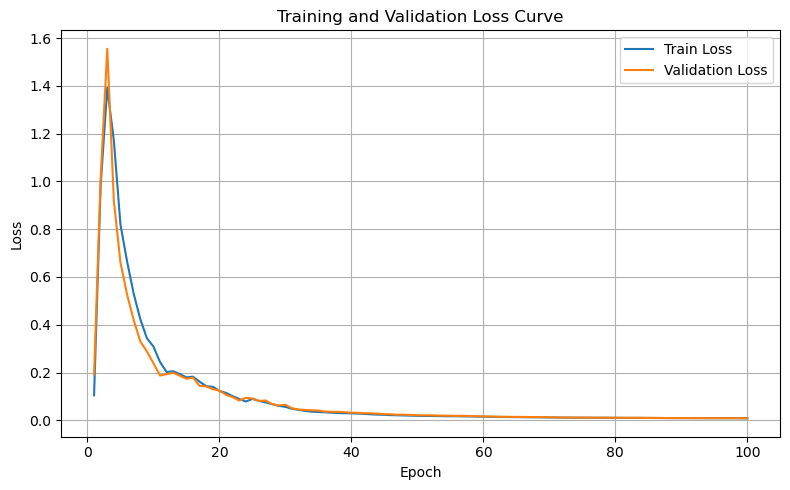

In [21]:
# draw the loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# evaluate on test set
model.eval()
test_loss = 0
with torch.no_grad():
    for full in test_loader:
        full = full.to(device)
        recon, vq_loss = model(full, full)
        recon_loss = F.mse_loss(recon, full)
        test_loss += (recon_loss + vq_loss).item()

print(f"Final Test Loss: {test_loss / len(test_loader):.4f}")

Final Test Loss: 0.0076
